# DS mentoring program. Module 3: classification I

## Summary

In [0]:
evaluator.print_scores()


Average cross-validation metrics
+-----------------------------+---------------------+---------------------+--------------------+
| model                       | f1_micro            | neg_log_loss        | roc_auc_macro_ovo  |
+-----------------------------+---------------------+---------------------+--------------------+
| Baseline                    | 0.8733301202561089  | 0.5013919079100155  | 0.9450214463653444 |
+-----------------------------+---------------------+---------------------+--------------------+
| L2                          | 0.8692392481845556  | 0.4443651811927085  | 0.9528786561200944 |
+-----------------------------+---------------------+---------------------+--------------------+
| (L2) 1.5 IQR                | 0.9153198653198652  | 0.2906418316167751  | 0.9407080292022338 |
+-----------------------------+---------------------+---------------------+--------------------+
| (L2) 3.0 IQR                | 0.8773564908895016  | 0.40991081766734966 | 0.949380060619346

**Results:**

1. L2-regilarization didn't influence much on model scores, but multiplied the speed of convergence
2. Despite 1.5 IQR rule removed 19% of initial data, it has noticeably increased our scores
3. KNN model has performed worse comparing to logistic regression
4. Feature engineering raised scores. Max increment has given the polynomial feature generation
5. Hyperparameters tuning also influenced our scores in good way

**Working with disbalanced data:**

* Undersampling - decreased scores because of smaller amount of training set
* Undersampling (custom) - comparing to simple undersampling, produced worse scores
* SMOTE & SMOTEENN - here's a little pitfall. Although we are increasing scores, we are also increasing chanses of model to get overfitted with generated samples
* Balanced weights - have showed dramatically dercrease of scores

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# from pandas_profiling import ProfileReport
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, roc_auc_score, f1_score, make_scorer, plot_confusion_matrix, roc_curve, precision_recall_curve, average_precision_score

# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from tabulate import tabulate

# ignore FutureWarnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')

RANDOM_SEED = 57

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (!) Task

**Overview**

* Thyroid Disease dataset: http://archive.ics.uci.edu/ml/datasets/thyroid+disease
* Target – Class

**Evaluation Criteria**

*	EDA: exploration of variables and properties of data with conclusions
*	Data preprocessing if needed: Handling missing values, Dropping unimportant features, Data normalization, Categorical encoding, Scikit pipeline usage
*	Metrics and cross-validation chosen as well as reasoning behind
*	Different techniques for handling imbalance data (over\under sampling, class weight)
*	Feature engineering e.g. transformations (nonlinear)
*	Feature importance and hyperparameters tuning

**Models**

* Logistic Regression
* Logistic Regression with regularization
* K-nearest neighbors

## Attribute information

(29 attribute values), diagnoses [record identification]
  
  Attribute Name - Possible Values

	-----------------------------
	age:				continuous.
	sex:				M, F.
	on thyroxine:			f, t.
	query on thyroxine:		f, t.
	on antithyroid medication:	f, t.
	sick:				f, t.
	pregnant:			f, t.
	thyroid surgery:		f, t.
	I131 treatment:			f, t.
	query hypothyroid:		f, t.
	query hyperthyroid:		f, t.
	lithium:			f, t.
	goitre:				f, t.
	tumor:				f, t.
	hypopituitary:			f, t.
	psych:				f, t.
	TSH measured:			f, t.
	TSH:				continuous.
	T3 measured:			f, t.
	T3:				continuous.
	TT4 measured:			f, t.
	TT4:				continuous.
	T4U measured:			f, t.
	T4U:				continuous.
	FTI measured:			f, t.
	FTI:				continuous.
	TBG measured:			f, t.
	TBG:				continuous.
	referral source:		WEST, STMW, SVHC, SVI, SVHD, other.

## EDA

In [0]:
df = pd.read_csv('/content/drive/My Drive/data/module_3/thyroid0387data.csv', sep=',', decimal=b'.')
df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Unnamed: 29,Unnamed: 30
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,?,f,?,f,?,f,?,f,?,other,-[840801013],NaN
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128,f,?,f,?,f,?,other,-[840801014],NaN
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,t,11,other,-[840801042],NaN
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,t,26,other,-[840803046],NaN
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,t,36,other,S[840803047],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,?,f,?,t,64,t,0.83,t,77,f,?,SVI,-[870119022],NaN
9168,22,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,t,91,t,0.92,t,99,f,?,SVI,-[870119023],NaN
9169,69,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,t,113,t,1.27,t,89,f,?,SVI,I[870119025],NaN
9170,47,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,t,75,t,0.85,t,88,f,?,other,-[870119027],NaN


### Data exploration

In [0]:
df = df.replace('?', np.nan)

### Empty rows/columns

In [0]:
null_columns = list(df.columns[df.isnull().all()])
print('Null columns:\n' + str(null_columns))

null_rows = list(df.loc[df.isnull().all(axis=1)].index)
print('\nNull rows:\n' + str(null_rows))

Null columns:
['Unnamed: 30']

Null rows:
[]


In [0]:
df = df.drop('Unnamed: 30', axis=1)

### General data set info

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        9172 non-null   int64 
 1   sex                        8865 non-null   object
 2   on thyroxine               9172 non-null   object
 3   query on thyroxine         9172 non-null   object
 4   on antithyroid medication  9172 non-null   object
 5   sick                       9172 non-null   object
 6   pregnant                   9172 non-null   object
 7   thyroid surgery            9172 non-null   object
 8   I131 treatment             9172 non-null   object
 9   query hypothyroid          9172 non-null   object
 10  query hyperthyroid         9172 non-null   object
 11  lithium                    9172 non-null   object
 12  goitre                     9172 non-null   object
 13  tumor                      9172 non-null   object
 14  hypopitu

In [0]:
new_numeric_cols = ['TSH', 'T3',	'TT4', 'T4U',	'FTI', 'TBG']
df[new_numeric_cols] = df[new_numeric_cols].astype(np.float64)

In [0]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,9172.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057
std,1183.976718,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000


In [0]:
df.describe(include='object')

,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,T3 measured,TT4 measured,T4U measured,FTI measured,TBG measured,referral source,Unnamed: 29
count,8865,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172,9172
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,9172
top,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,t,t,t,t,f,other,-[860819048]
freq,6073,7932,9019,9056,8828,9065,9038,9003,8542,8521,9079,9088,8931,9170,8754,8330,6568,8730,8363,8370,8823,5493,1


**t/f columns**

In [0]:
str_cols = list(df.drop(['sex', 'referral source', 'Unnamed: 29'], axis=1).select_dtypes(np.object)).copy()

for i, col in enumerate(str_cols):
  vc = df[col].value_counts()
  if set(vc.index) == set(['t', 'f']):
    df[col].replace({'f': 0, 't': 1}, inplace=True)

df[str_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   on thyroxine               9172 non-null   int64
 1   query on thyroxine         9172 non-null   int64
 2   on antithyroid medication  9172 non-null   int64
 3   sick                       9172 non-null   int64
 4   pregnant                   9172 non-null   int64
 5   thyroid surgery            9172 non-null   int64
 6   I131 treatment             9172 non-null   int64
 7   query hypothyroid          9172 non-null   int64
 8   query hyperthyroid         9172 non-null   int64
 9   lithium                    9172 non-null   int64
 10  goitre                     9172 non-null   int64
 11  tumor                      9172 non-null   int64
 12  hypopituitary              9172 non-null   int64
 13  psych                      9172 non-null   int64
 14  TSH measured            

**Age**

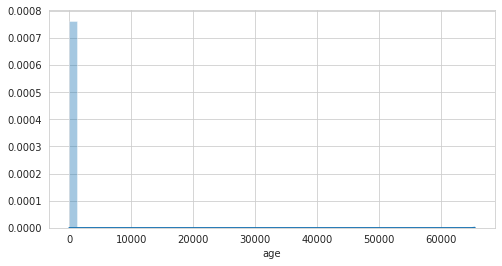

In [0]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df['age']);

Obviously, we have some outliers in 'age' column... Let's remove those rows.

In [0]:
df[df['age'] > 100]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Unnamed: 29
2976,455,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.10,1,2.0,1,118.0,1,1.13,1,104.0,0,NaN,SVI,-[850530001]
5710,65511,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.38,1,2.0,1,113.0,1,1.08,1,104.0,0,NaN,other,-[860210008]
6392,65512,M,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.03,1,2.8,1,112.0,1,0.84,1,133.0,0,NaN,other,-[860403050]
8105,65526,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.50,0,NaN,1,132.0,1,1.02,1,129.0,0,NaN,other,-[861014041]


In [0]:
df = df[df['age'] <= 100]

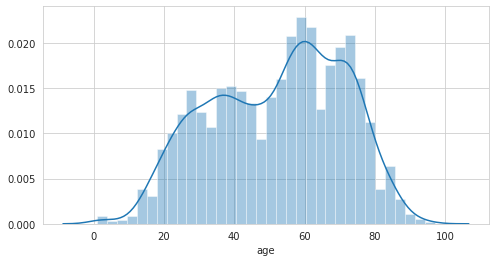

In [0]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df['age']);

**Sex**

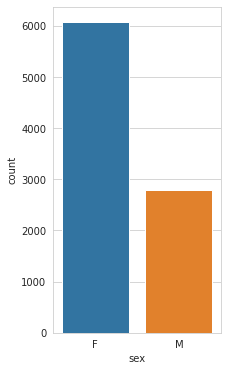

In [0]:
fig, ax = plt.subplots(figsize=(3,6))
sns.countplot(df['sex']);

**Referral source**

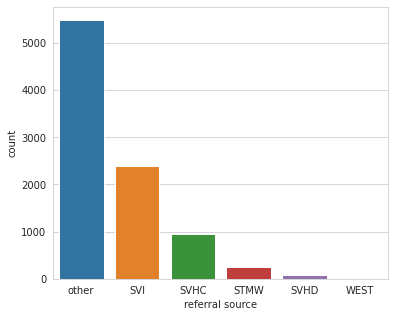

In [0]:
fig, ax = plt.subplots(figsize=(6,5))
sns.countplot(df['referral source']);

In [0]:
df['referral source'].value_counts()

other    5490
SVI      2393
SVHC      956
STMW      255
SVHD       71
WEST        3
Name: referral source, dtype: int64

In [0]:
df[df['referral source'] == 'WEST']

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Unnamed: 29
353,22,F,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,1,149.0,1,1.38,1,108.0,0,NaN,WEST,I[840911016]
1527,23,F,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,NaN,1,171.0,1,1.29,1,133.0,0,NaN,WEST,-[841206041]
1659,44,F,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,1,154.0,1,1.06,1,146.0,0,NaN,WEST,-[841214020]


In [0]:
df['referral source'] = df['referral source'].replace('WEST', 'other')

### Normality test

In [0]:
def test_for_normality_dagostino(data):
  stat, p = normaltest(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
  	print('Sample looks Gaussian (fail to reject H0)')
  else:
	  print('Sample does not look Gaussian (reject H0)')

def test_for_normality_shapiro(data):
  stat, p = shapiro(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
  	print('Sample looks Gaussian (fail to reject H0)')
  else:
	  print('Sample does not look Gaussian (reject H0)')

def test_for_normality(data, graph=True):
  print('Test {} column for normality:'.format(data.name))
  if data.size > 5000:
    print('D’Agostino’s K^2 Test beacause there are {} values (more than 5k)'.format(data.size))
    test_for_normality_dagostino(data)
  else:
    print('Shapiro-Wilk Test beacause there are {} values (less than 5k)'.format(data.size))
    test_for_normality_shapiro(data)
  if (graph):
    qqplot(df['age'], line='s')
    plt.show()


In [0]:
numeric_cols = ['age', 'TSH', 'T3',	'TT4', 'T4U',	'FTI', 'TBG']

Test age column for normality:
D’Agostino’s K^2 Test beacause there are 9168 values (more than 5k)
Statistics=1206.477, p=0.000
Sample does not look Gaussian (reject H0)


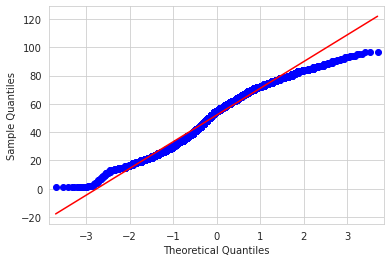

In [0]:
test_for_normality(df['age'].dropna())

Test TSH column for normality:
D’Agostino’s K^2 Test beacause there are 8326 values (more than 5k)
Statistics=14814.262, p=0.000
Sample does not look Gaussian (reject H0)


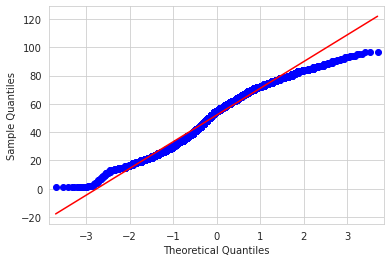

In [0]:
test_for_normality(df['TSH'].dropna())

Test T3 column for normality:
D’Agostino’s K^2 Test beacause there are 6565 values (more than 5k)
Statistics=4779.831, p=0.000
Sample does not look Gaussian (reject H0)


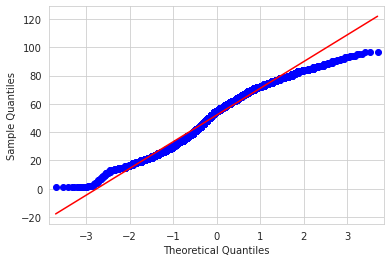

In [0]:
test_for_normality(df['T3'].dropna())

Test TT4 column for normality:
D’Agostino’s K^2 Test beacause there are 8726 values (more than 5k)
Statistics=3221.321, p=0.000
Sample does not look Gaussian (reject H0)


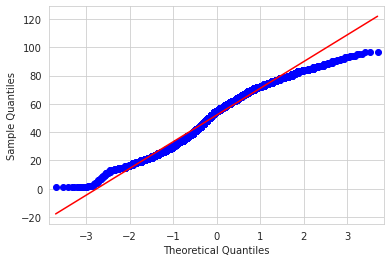

In [0]:
test_for_normality(df['TT4'].dropna())

Test T4U column for normality:
D’Agostino’s K^2 Test beacause there are 8359 values (more than 5k)
Statistics=1917.133, p=0.000
Sample does not look Gaussian (reject H0)


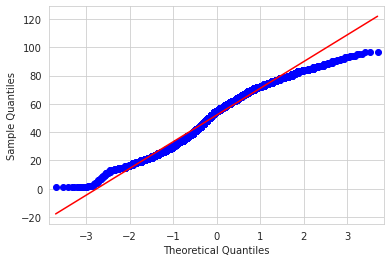

In [0]:
test_for_normality(df['T4U'].dropna())

Test FTI column for normality:
D’Agostino’s K^2 Test beacause there are 8366 values (more than 5k)
Statistics=7594.503, p=0.000
Sample does not look Gaussian (reject H0)


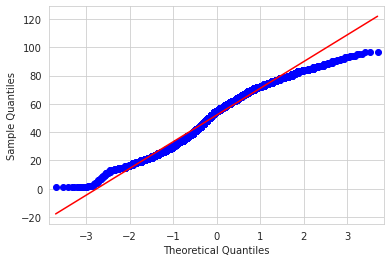

In [0]:
test_for_normality(df['FTI'].dropna())

Test TBG column for normality:
Shapiro-Wilk Test beacause there are 349 values (less than 5k)
Statistics=0.570, p=0.000
Sample does not look Gaussian (reject H0)


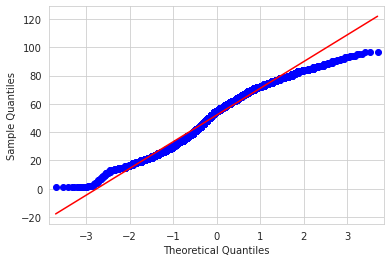

In [0]:
test_for_normality(df['TBG'].dropna())

As we see, none of our numerical data has normal distribution. That's why we'll use QuantileTransformer to normalize data in pipeline.

### Profile report (doesn't work)

In [0]:
# ProfileReport(df) # concat() got an unexpected keyword argument 'join_axes'

## Data preprocessing

### Add 'class' feature

As it's said in the description to the data set column 'Unnamed: 29' contains 'diagnoses [record identification]'. Well, we don't need record id, so just drop it.

In [0]:
df['class'] = df['Unnamed: 29'].astype(str).str[0]
df.drop('Unnamed: 29', axis=1, inplace=True)
df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,class
0,29,F,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.3,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,other,-
1,29,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.6,1,1.9,1,128.0,0,NaN,0,NaN,0,NaN,other,-
2,41,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,11.0,other,-
3,36,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,26.0,other,-
4,32,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,36.0,other,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,NaN,1,64.0,1,0.83,1,77.0,0,NaN,SVI,-
9168,22,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,1,91.0,1,0.92,1,99.0,0,NaN,SVI,-
9169,69,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,1,113.0,1,1.27,1,89.0,0,NaN,SVI,I
9170,47,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,1,75.0,1,0.85,1,88.0,0,NaN,other,-


In [0]:
df['class'].describe(include='object')

count     9168
unique      20
top          -
freq      6767
Name: class, dtype: object

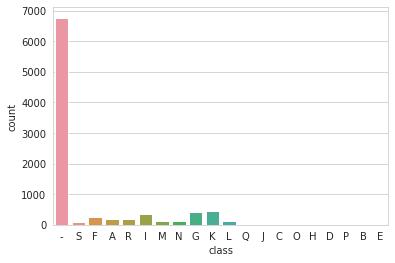

In [0]:
ax = sns.countplot(df['class'])

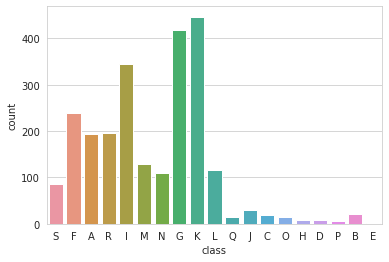

In [0]:
ax = sns.countplot(df[df['class'] != '-']['class'])

### Missing values

In [0]:
print(df.isnull().sum())

age                             0
sex                           307
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           842
T3 measured                     0
T3                           2603
TT4 measured                    0
TT4                           442
T4U measured                    0
T4U                           809
FTI measured                    0
FTI                           802
TBG measured                    0
TBG                          8819
referral source                 0
class         

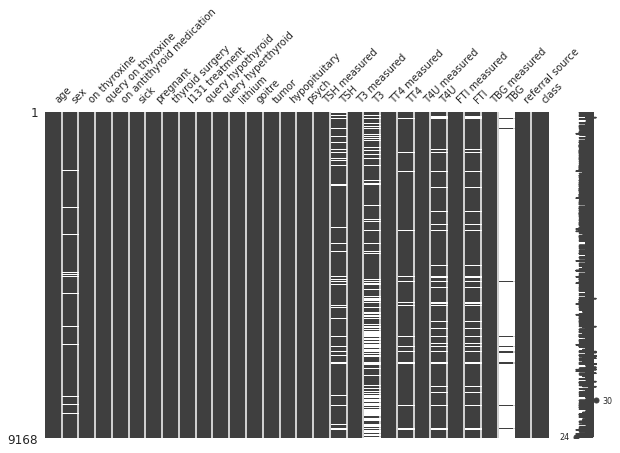

In [0]:
msno.matrix(df, figsize=(10, 6), fontsize=10);

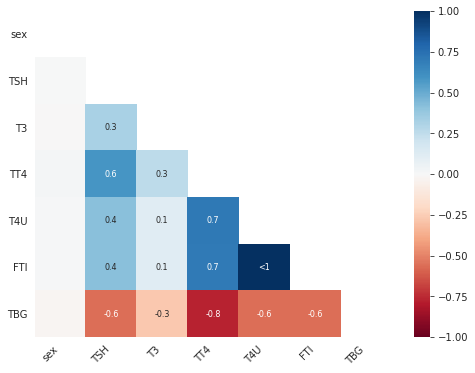

In [0]:
msno.heatmap(df, figsize=(8, 6), fontsize=10);

Feature 'TBG' has a lot of skipped data that wasn't measured. It seems, that we'll have to skip those two columns.

In [0]:
df.drop(['TBG', 'TBG measured'], axis=1, inplace=True)

### Outliers

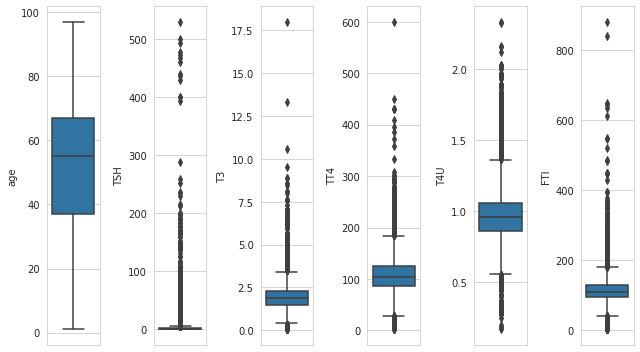

In [0]:
numeric_cols = ['age', 'TSH', 'T3',	'TT4', 'T4U',	'FTI']

plt.figure(figsize = (1.5*len(numeric_cols), 5))
for i, col in enumerate(numeric_cols):
  plt.subplot(1, len(numeric_cols), i+1)
  ax = sns.boxplot(df[col], orient='v')
  plt.tight_layout();

TSH feature seems to be highly-outliered.

### Features correlation

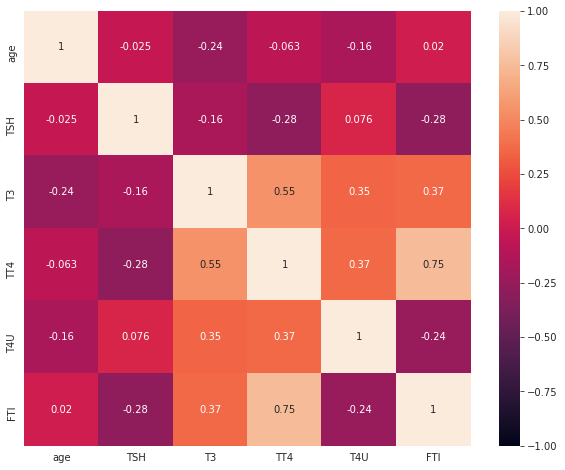

In [0]:
numeric_cols = ['age', 'TSH', 'T3',	'TT4', 'T4U',	'FTI']

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, vmin=-1, vmax=1);

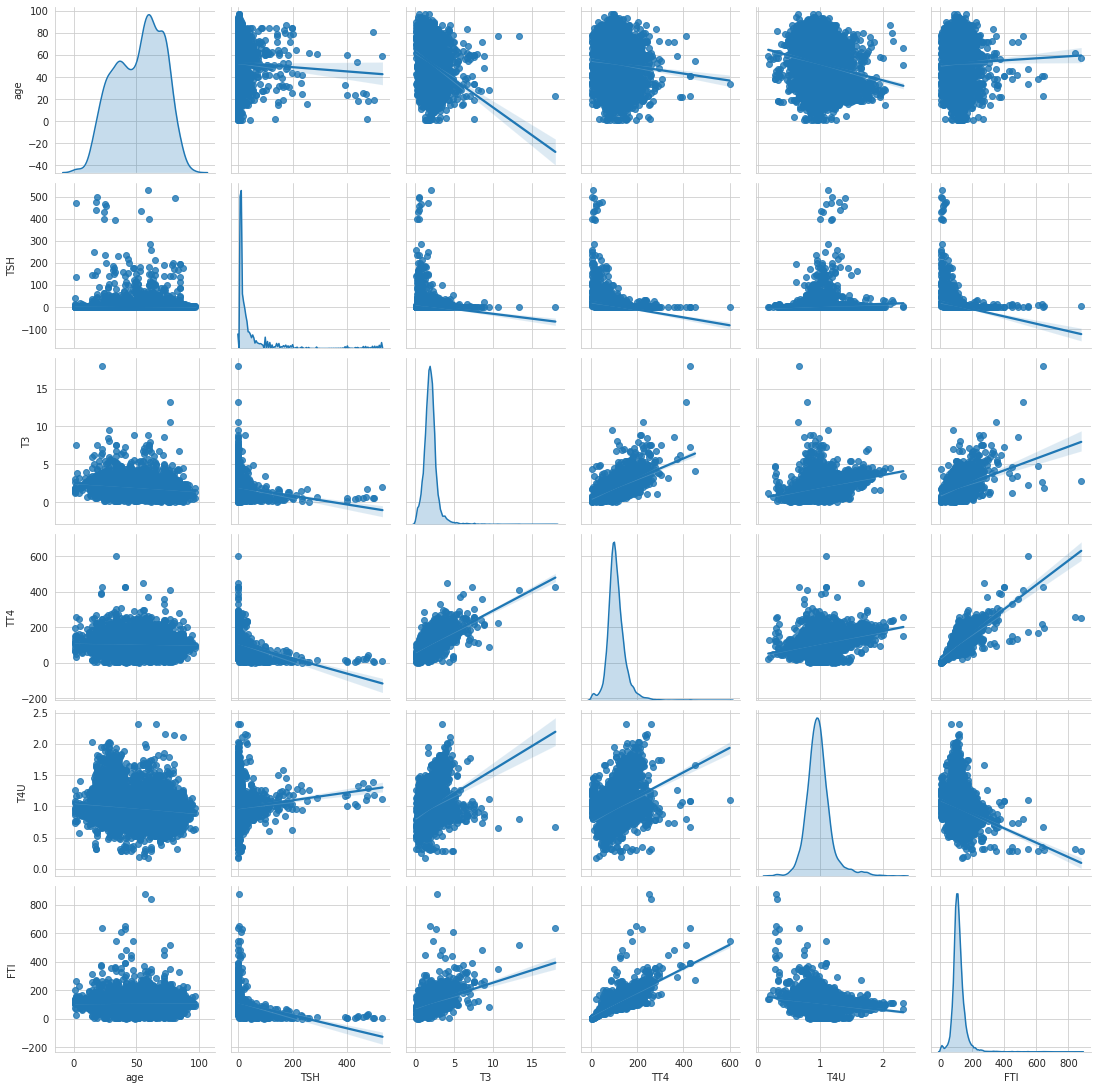

In [0]:
numeric_cols = ['age', 'TSH', 'T3',	'TT4', 'T4U',	'FTI']

# pairplot_data = df[numeric_cols].sample(100).copy() # temporary 100 to speed up running
pairplot_data = df[numeric_cols]
sns.pairplot(pairplot_data, kind='reg', diag_kind='kde');

### Redundant data

We'll check whether features and their 'measured' markers are coincides.

In [0]:
features = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
features_measured = list()

redundancy_marker = True
for feature in features:
  feature_measured = feature + ' measured'
  features_measured.append(feature_measured)
  equality = df[feature].isna().sum() == (df[feature_measured].value_counts()[0])
  if (not equality):
    redundancy_marker = False
  print('{} and {}: {}'.format(feature, feature_measured, equality))

if (redundancy_marker):
  df.drop(features_measured, axis=1, inplace=True)

TSH and TSH measured: True
T3 and T3 measured: True
TT4 and TT4 measured: True
T4U and T4U measured: True
FTI and FTI measured: True


## Data preparation

### 1.5 IQR rule

In [0]:
def remove_outliers(data, outlired_cols, IQR_constant=1.5):
  df_outliers = data.copy()

  number_before_removing = df_outliers.shape[0]
  print('Number of rows before removing: ' + str(number_before_removing))

  q1 = df_outliers[outlired_cols].quantile(0.25)
  q3 = df_outliers[outlired_cols].quantile(0.75)
  IQR = q3 - q1
  IQR_condition = (df_outliers[outlired_cols] <= (q1 - IQR_constant * IQR)) | (df_outliers[outlired_cols] >= (q3 + IQR_constant * IQR))
  df_outliers = df_outliers[~IQR_condition.any(axis=1)]

  number_after_removing = df_outliers.shape[0]
  print('Number of rows after removing: ' + str(number_after_removing))
  dif = number_before_removing - number_after_removing
  rel = int(dif / number_before_removing * 100)
  print('{} rows ({} %) were removed as outliers applying IQR rule'.format(str(dif), str(rel)))
  
  return df_outliers

In [0]:
outlired_columns = ['TSH', 'T3',	'TT4', 'T4U',	'FTI']
df_removed_outliers = remove_outliers(df, outlired_columns)

Number of rows before removing: 9168
Number of rows after removing: 7425
1743 rows (19 %) were removed as outliers applying IQR rule


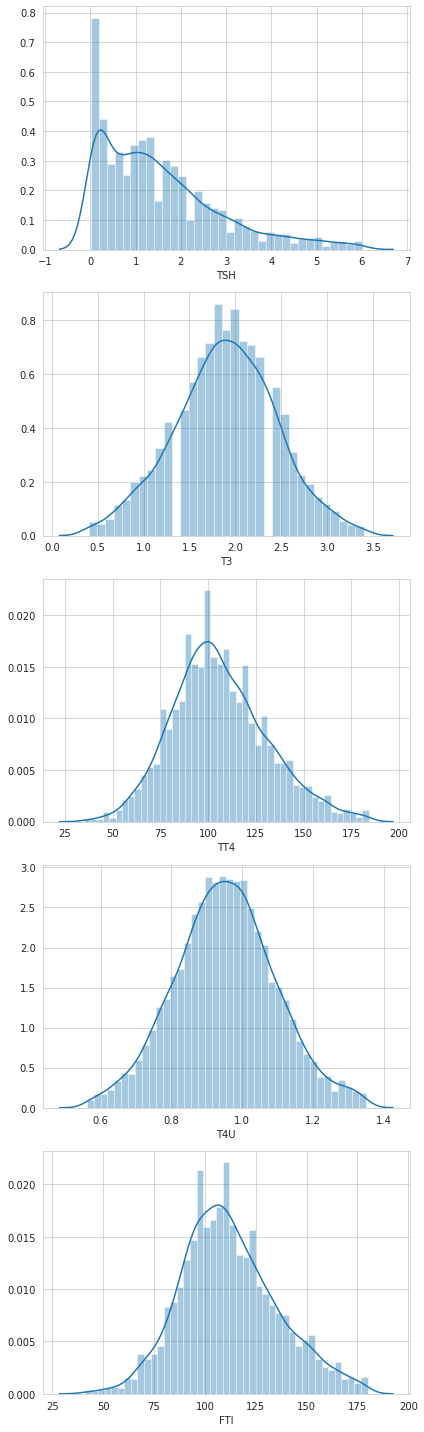

In [0]:
numeric_cols = ['TSH', 'T3',	'TT4', 'T4U',	'FTI']

plt.figure(figsize = (6, 4*len(numeric_cols)))
for i, col in enumerate(numeric_cols):
  plt.subplot(len(numeric_cols), 1, i+1)
  ax = sns.distplot(df_removed_outliers[col])
  plt.tight_layout();


**Repeat the normality test**

In [0]:
for col in numeric_cols:
  print('\n')
  test_for_normality(df_removed_outliers[col].dropna(), graph=False)



Test TSH column for normality:
D’Agostino’s K^2 Test beacause there are 6643 values (more than 5k)
Statistics=1016.587, p=0.000
Sample does not look Gaussian (reject H0)


Test T3 column for normality:
D’Agostino’s K^2 Test beacause there are 5268 values (more than 5k)
Statistics=6.871, p=0.032
Sample does not look Gaussian (reject H0)


Test TT4 column for normality:
D’Agostino’s K^2 Test beacause there are 6999 values (more than 5k)
Statistics=164.623, p=0.000
Sample does not look Gaussian (reject H0)


Test T4U column for normality:
D’Agostino’s K^2 Test beacause there are 6692 values (more than 5k)
Statistics=6.587, p=0.037
Sample does not look Gaussian (reject H0)


Test FTI column for normality:
D’Agostino’s K^2 Test beacause there are 6698 values (more than 5k)
Statistics=116.208, p=0.000
Sample does not look Gaussian (reject H0)


T4U and T3 are close to be normally distributed, but didn't pass statistical test.

### Distinguish target data

In [0]:
# target_cols = list(pd.get_dummies(df['class'], prefix='class').columns)
df['class'].value_counts()

-    6767
K     447
G     419
I     346
F     239
R     196
A     193
M     129
L     116
N     110
S      85
J      30
B      21
C      18
O      15
Q      14
D       9
H       8
P       5
E       1
Name: class, dtype: int64

In [0]:
# df = df[~df['class'].str.contains('E')] # only one sample
# small_groups = ['E', 'H', 'C', 'O', 'M', 'Q', 'P'] # applying 1.5 IQR rule
small_groups = ['E', 'H', 'C', 'O', 'Q', 'P', 'D']
df['class'] = df['class'].replace(small_groups, 'grouped')

In [0]:
def print_pie_chart(data):
  sizes = data.value_counts().to_numpy()
  labels = list(pd.get_dummies(data).columns)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90);
  plt.show()

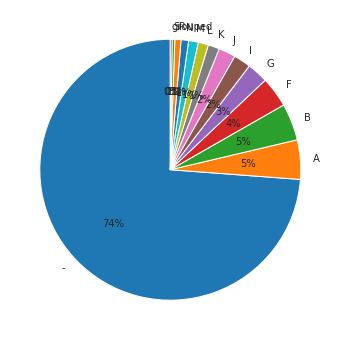

In [0]:
print_pie_chart(df['class'])

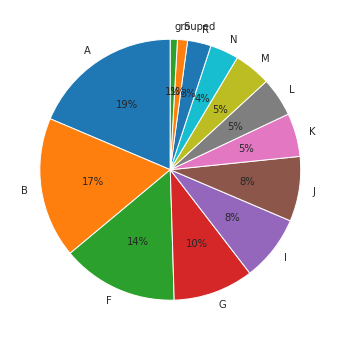

In [0]:
print_pie_chart(df[df['class'] != '-']['class'])

### Finalize data

In [0]:
final_df = df.copy()
final_df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,class
0,29,F,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.3,NaN,NaN,NaN,NaN,other,-
1,29,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.6,1.9,128.0,NaN,NaN,other,-
2,41,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,-
3,36,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,-
4,32,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,64.0,0.83,77.0,SVI,-
9168,22,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,91.0,0.92,99.0,SVI,-
9169,69,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,113.0,1.27,89.0,SVI,I
9170,47,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,75.0,0.85,88.0,other,-


In [0]:
x = final_df.drop('class', axis=1).copy()
y = final_df['class'].copy()

### Pipeline 

(cross-validation, normalization)

In [0]:
numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
numeric_transformer = Pipeline([
  ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
  ('scale', MinMaxScaler()),
  ('normalize', QuantileTransformer(output_distribution='normal')) # normalize data
])

str_cols = list(x.select_dtypes(np.object))
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

binary_cols = list(x.drop(numeric_cols, axis=1).select_dtypes(np.number))
binary_transformer = Pipeline([
  ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, str_cols),
        ('bin', binary_transformer, binary_cols)
    ])

### Train/test split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=RANDOM_SEED, stratify=y)

## Baseline

In [0]:
class Evaluator:

  total_scores = dict()
  models = dict()

  def __init__(self, metrics):
    self.metrics = metrics

  def set_metrics(self, metrics):
    self.metrics = metrics

  def get_model(self, name):
    return self.models[name]

  def test_model(self, name, model, x, y, folds=3, preprocess=True):
    self.models[name] = model
    steps = [('preprocessor', preprocessor), ('classifier', model)]
    if (not preprocess):
      print('skip preprocessing...')
      steps = [('classifier', model)]
    clf = Pipeline(steps=steps)
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_SEED)

    model_scores = cross_validate(clf, x, y, scoring=self.metrics, cv=cv)
    self.total_scores[name] = self._process_scores(model_scores)
    self.print_scores(name)

  def _process_scores(self, model_scores):
    model_scores.pop('fit_time', None)
    model_scores.pop('score_time', None)
    mean_scores = dict()
    for k, v in model_scores.items():
      mean_scores[k] = abs(np.mean(v))
    return list(mean_scores.values())

  def print_scores(self, name='none'):
    if type(self.metrics) is dict:
      accuracy = list([['model'] + list(self.metrics.keys())])
    elif type(self.metrics) is list:
      accuracy = list([['model'] + self.metrics])

    if (name != 'none'):
      accuracy.append([name] + self.total_scores[name])
    else:
      for k, v in self.total_scores.items():
        accuracy.append([k] + v)

    print('\nAverage cross-validation metrics')
    print(tabulate(accuracy, tablefmt='grid'))

### Metrics

As we are going to balance our data, we'll use the following metrics:

* F1 score*
* AUC ROC**
* Logloss

*F1 score:

As we have label imbalance, we'll use 'micro' f1 score: "Calculate metrics globally by counting the total true positives, false negatives and false positives."

**AUC ROC:

'ovo': Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average == 'macro'.

In [0]:
f1 = make_scorer(f1_score, average='micro')

roc_auc = make_scorer(roc_auc_score, average='macro', multi_class='ovo', needs_proba=True)

metrics = {
    'f1_micro': f1, 
    'neg_log_loss': 'neg_log_loss', 
    'roc_auc_macro_ovo': roc_auc
}

**Confusion matrix**

In [0]:
def print_confusion_matrix(model, x, y, preprocess=True):
  if preprocess:
    pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
    ])
    x = pipeline.fit_transform(x)
  else:
    print('skip preprocessing...')
  model.fit(x, y)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp = plot_confusion_matrix(model, x, y,
                               cmap=plt.cm.Blues,
                               ax=ax);
  disp.ax_.set_title('Confusion matrix, without normalization');

  plt.show();

### Baseline model

In [0]:
evaluator = Evaluator(metrics)

log_reg = LogisticRegression(penalty='none', max_iter=5000, multi_class='multinomial') # 4000 converged; l2: 300
evaluator.test_model('Baseline', log_reg, x_train, y_train)


Average cross-validation metrics
+----------+--------------------+--------------------+--------------------+
| model    | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+----------+--------------------+--------------------+--------------------+
| Baseline | 0.8733301202561089 | 0.5013919079100155 | 0.9450214463653444 |
+----------+--------------------+--------------------+--------------------+


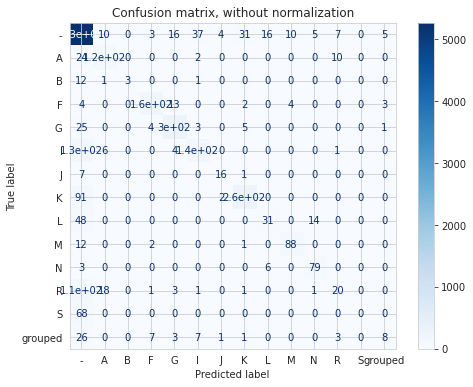

In [0]:
# Probably should use the first estimator ftom cross-validation
# estimator = cross_validate(pipeline, x, y, return_estimator=True, cv=5)
# And then take estimator['estimator'][0]

print_confusion_matrix(log_reg, x_train, y_train) 

### ROC-curve

In [0]:
model = log_reg

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
x_train_preprocessed = pipeline.fit_transform(x_train)
model.fit(x_train_preprocessed, y_train)

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_preprocessed = ohe.fit_transform(y_train.copy().to_numpy().reshape(-1, 1))
y_proba = model.predict_proba(x_train_preprocessed)

# best_th, ths = search_threshold(y_train_preprocessed, y_proba, verbose=False);

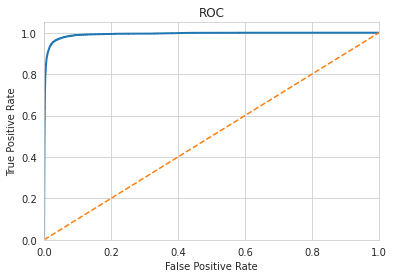

In [0]:
fpr, tpr, _ = roc_curve(y_train_preprocessed.ravel(), y_proba.ravel())

plt.figure()
plt.plot(fpr, tpr, lw=2);
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlim([0.0, 1.0]); 
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate');
plt.title('ROC');
plt.show();

### PR-curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.93')

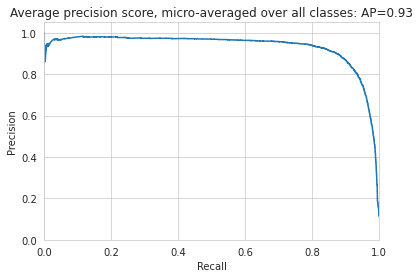

In [0]:
precision, recall, _ = precision_recall_curve(y_train_preprocessed.ravel(), y_proba.ravel())
average_precision = average_precision_score(y_train_preprocessed, y_proba, average="micro")

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision))

## L2-regularization

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, multi_class='multinomial')
evaluator.test_model('L2', log_reg, x_train, y_train)


Average cross-validation metrics
+-------+--------------------+--------------------+--------------------+
| model | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+-------+--------------------+--------------------+--------------------+
| L2    | 0.8692392481845556 | 0.4443651811927085 | 0.9528786561200944 |
+-------+--------------------+--------------------+--------------------+


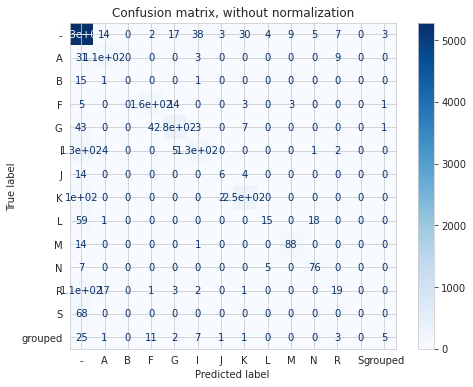

In [0]:
print_confusion_matrix(log_reg, x_train, y_train)

## Working with outliers

### 1.5 IQR rule

In [0]:
outlired_columns = ['TSH', 'T3',	'TT4', 'T4U',	'FTI']
df_removed_outliers = remove_outliers(final_df, outlired_columns)

Number of rows before removing: 9168
Number of rows after removing: 7425
1743 rows (19 %) were removed as outliers applying IQR rule


In [0]:
df_removed_outliers['class'].value_counts()

-          6500
K           392
R           137
I           122
L            86
S            85
A            38
N            24
grouped      18
J            10
B            10
M             3
Name: class, dtype: int64

In [0]:
df_removed_outliers['class'] = df_removed_outliers['class'].replace('M', 'grouped')

In [0]:
x_iqr = df_removed_outliers.drop('class', axis=1).copy()
y_iqr = df_removed_outliers['class'].copy()

In [0]:
x_iqr_train, x_iqr_test, y_iqr_train, y_iqr_test = train_test_split(x_iqr, y_iqr, test_size = 0.2, random_state=RANDOM_SEED, stratify=y_iqr)

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) 1.5 IQR', log_reg, x_iqr_train, y_iqr_train)


Average cross-validation metrics
+--------------+--------------------+--------------------+--------------------+
| model        | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+--------------+--------------------+--------------------+--------------------+
| (L2) 1.5 IQR | 0.9153198653198652 | 0.2906418316167751 | 0.9407080292022338 |
+--------------+--------------------+--------------------+--------------------+


### 3 IQR removing

In [0]:
outlired_columns = ['TSH', 'T3',	'TT4', 'T4U',	'FTI']
df_removed_outliers = remove_outliers(final_df, outlired_columns, IQR_constant=3)

Number of rows before removing: 9168
Number of rows after removing: 8358
810 rows (8 %) were removed as outliers applying IQR rule


In [0]:
df_removed_outliers['class'].value_counts()

-          6703
K           445
I           257
G           201
R           181
A           112
L           110
N            98
S            85
M            56
grouped      44
J            29
B            19
F            18
Name: class, dtype: int64

In [0]:
x_iqr = df_removed_outliers.drop('class', axis=1).copy()
y_iqr = df_removed_outliers['class'].copy()

In [0]:
x_iqr_train, x_iqr_test, y_iqr_train, y_iqr_test = train_test_split(x_iqr, y_iqr, test_size = 0.2, random_state=RANDOM_SEED, stratify=y_iqr)

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) 3.0 IQR', log_reg, x_iqr_train, y_iqr_train)


Average cross-validation metrics
+--------------+--------------------+---------------------+--------------------+
| model        | f1_micro           | neg_log_loss        | roc_auc_macro_ovo  |
+--------------+--------------------+---------------------+--------------------+
| (L2) 3.0 IQR | 0.8773564908895016 | 0.40991081766734966 | 0.9493800606193465 |
+--------------+--------------------+---------------------+--------------------+


## Resampling

**Class weights**

The weights from the class_weight parameter are used to train the classifier. They are not used in the calculation of any of the metrics you are using: with different class weights, the numbers will be different simply because the classifier is different.

Basically in every scikit-learn classifier, the class weights are used to tell your model how important a class is. That means that during the training, the classifier will make extra efforts to classify properly the classes with high weights.
How they do that is algorithm-specific. If you want details about how it works for SVC and the doc does not make sense to you, feel free to mention it.

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
])
x_train_transformed = pipeline.fit_transform(x_train)

### Undersampling major class

In [0]:
sampling_strategy = 'majority'
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_SEED)
x_train_resampled_rus, y_train_resampled_rus = rus.fit_resample(x_train_transformed, y_train.to_numpy())

K          358
G          335
I          277
F          191
R          157
A          154
M          103
L           93
N           88
S           68
grouped     56
J           24
-           17
B           17
dtype: int64


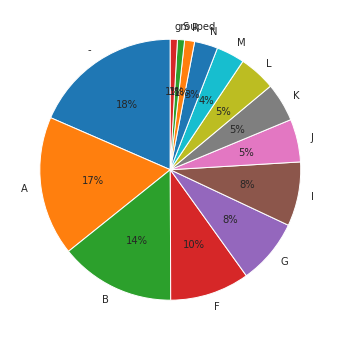

In [0]:
y_train_resampled_rus = pd.Series(y_train_resampled_rus)

print(y_train_resampled_rus.value_counts())
print_pie_chart(y_train_resampled_rus)

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) Undersampling', log_reg, x_train_resampled_rus, y_train_resampled_rus, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+--------------------+--------------------+--------------------+--------------------+
| model              | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+--------------------+--------------------+--------------------+--------------------+
| (L2) Undersampling | 0.8230134158926727 | 0.6149568629383254 | 0.9591655955260716 |
+--------------------+--------------------+--------------------+--------------------+


skip preprocessing...


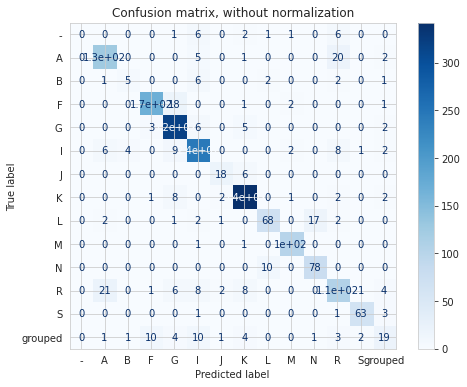

In [0]:
print_confusion_matrix(log_reg, x_train_resampled_rus, y_train_resampled_rus, preprocess=False)

### Undersampling major class using custom dict

In [0]:
sampling_strategy = y_train.value_counts().to_dict()
sampling_strategy['-'] = int(sampling_strategy['K'] * 1.5)

In [0]:
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_SEED)
x_train_resampled_rus, y_train_resampled_rus = rus.fit_resample(x_train_transformed, y_train.to_numpy())

-          537
K          358
G          335
I          277
F          191
R          157
A          154
M          103
L           93
N           88
S           68
grouped     56
J           24
B           17
dtype: int64


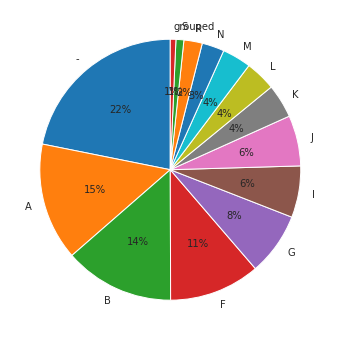

In [0]:
y_train_resampled_rus = pd.Series(y_train_resampled_rus)

print(y_train_resampled_rus.value_counts())
print_pie_chart(y_train_resampled_rus)

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) Undersampling (custom)', log_reg, x_train_resampled_rus, y_train_resampled_rus, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+-----------------------------+--------------------+--------------------+--------------------+
| model                       | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+-----------------------------+--------------------+--------------------+--------------------+
| (L2) Undersampling (custom) | 0.7660740343667175 | 0.7726648214399132 | 0.9561378251775928 |
+-----------------------------+--------------------+--------------------+--------------------+


### Oversampling with SMOTE

In [0]:
x_train_resampled_ovr, y_train_resampled_ovr = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train_transformed, y_train.to_numpy())

In [0]:
y_train_resampled_ovr = pd.Series(y_train_resampled_ovr)

print(y_train_resampled_ovr.value_counts())
# print_pie_chart(y_train_resampled_ovr)

I          5413
R          5413
A          5413
N          5413
J          5413
F          5413
grouped    5413
K          5413
L          5413
-          5413
G          5413
B          5413
M          5413
S          5413
dtype: int64


In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
evaluator.test_model('(L2) SMOTE oversmapling', log_reg, x_train_resampled_ovr, y_train_resampled_ovr, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+-------------------------+--------------------+--------------------+--------------------+
| model                   | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+-------------------------+--------------------+--------------------+--------------------+
| (L2) SMOTE oversmapling | 0.8686891340548772 | 0.4405591733949515 | 0.9861701367191201 |
+-------------------------+--------------------+--------------------+--------------------+


skip preprocessing...


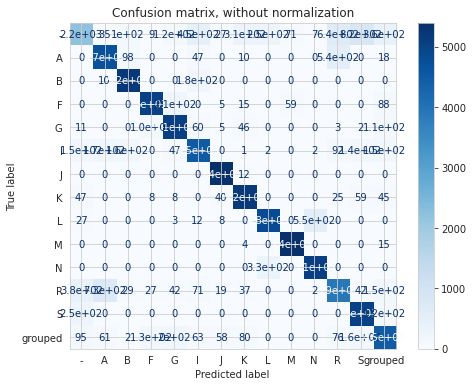

In [0]:
print_confusion_matrix(log_reg, x_train_resampled_ovr, y_train_resampled_ovr, preprocess=False)

### SMOTEENN

Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [0]:
sampling_strategy = 'not majority'
se = SMOTEENN(sampling_strategy=sampling_strategy, random_state=RANDOM_SEED)
x_train_resampled_se, y_train_resampled_se = se.fit_resample(x_train_transformed, y_train.to_numpy())

In [0]:
y_train_resampled_se = pd.Series(y_train_resampled_se)

print(y_train_resampled_se.value_counts())
# print_pie_chart(y_train_resampled_se)

J          5413
grouped    5413
B          5413
M          5413
N          5407
L          5403
F          5401
G          5401
A          5400
K          5398
R          5396
I          5389
S          5227
-          3892
dtype: int64


In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
evaluator.test_model('(L2) SMOTEENN', log_reg, x_train_resampled_se, y_train_resampled_se, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+---------------+--------------------+---------------------+--------------------+
| model         | f1_micro           | neg_log_loss        | roc_auc_macro_ovo  |
+---------------+--------------------+---------------------+--------------------+
| (L2) SMOTEENN | 0.8824730233528119 | 0.39569302697246833 | 0.9885962191034235 |
+---------------+--------------------+---------------------+--------------------+


skip preprocessing...


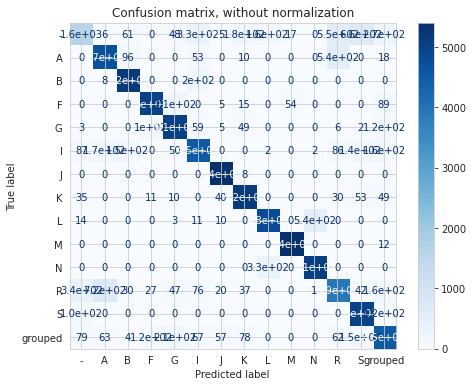

In [0]:
print_confusion_matrix(log_reg, x_train_resampled_se, y_train_resampled_se, preprocess=False)

### Weighted parameters

In [0]:
log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) Balanced', log_reg, x_train, y_train)


Average cross-validation metrics
+---------------+---------------------+--------------------+--------------------+
| model         | f1_micro            | neg_log_loss       | roc_auc_macro_ovo  |
+---------------+---------------------+--------------------+--------------------+
| (L2) Balanced | 0.45282254330681426 | 1.3248301506664608 | 0.9643884345098316 |
+---------------+---------------------+--------------------+--------------------+


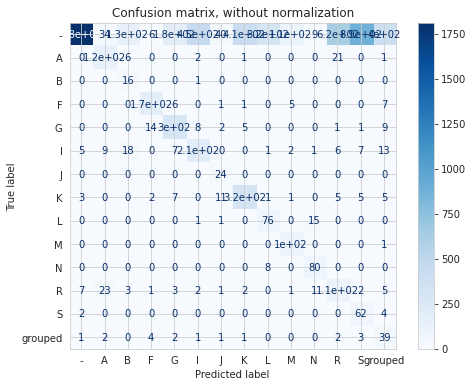

In [0]:
print_confusion_matrix(log_reg, x_train, y_train)

## KNN

In [0]:
evaluator = Evaluator(metrics)

knn = KNeighborsClassifier(algorithm='kd_tree', weights='distance')
evaluator.test_model('KNN', knn, x_train, y_train)


Average cross-validation metrics
+-------+--------------------+--------------------+--------------------+
| model | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+-------+--------------------+--------------------+--------------------+
| KNN   | 0.8232893431823075 | 2.1953748898353656 | 0.8401465353012721 |
+-------+--------------------+--------------------+--------------------+


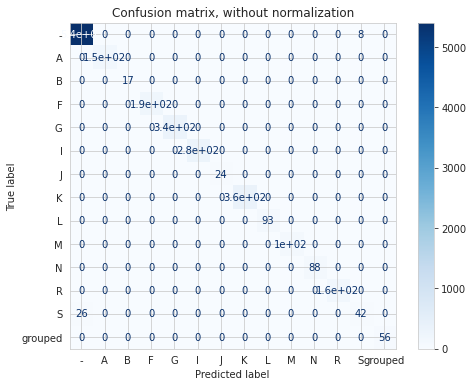

In [0]:
print_confusion_matrix(knn, x_train, y_train)

### Resampling: SMOTEENN

Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [0]:
knn = KNeighborsClassifier(algorithm='kd_tree', weights='distance')
evaluator.test_model('KNN SMOTEENN', knn, x_train_resampled_se, y_train_resampled_se, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+--------------+--------------------+--------------------+--------------------+
| model        | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+--------------+--------------------+--------------------+--------------------+
| KNN SMOTEENN | 0.9941054072701222 | 0.0348729790735297 | 0.9994807036603001 |
+--------------+--------------------+--------------------+--------------------+


skip preprocessing...


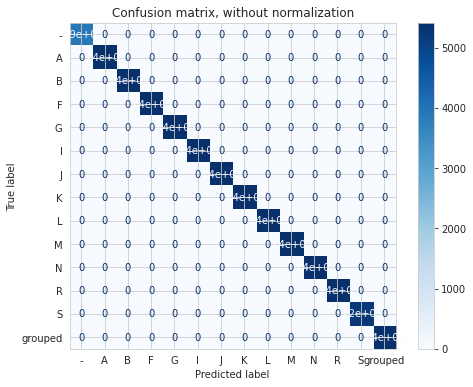

In [0]:
print_confusion_matrix(knn, x_train_resampled_se, y_train_resampled_se, preprocess=False)

## Feature Engineering

### Nonlinear transformations

In [0]:
x_train_numeric = x_train[numeric_cols]

neg_values = np.sum(x_train_numeric < 0, axis=0)
print('Negative values in initial data:\n' + str(neg_values))

Negative values in initial data:
age    0
TSH    0
T3     0
TT4    0
T4U    0
FTI    0
dtype: int64


In [0]:
x_train_numeric = x_train_numeric.fillna(x_train_numeric.median())

x_train_numeric_positive = x_train_numeric[(x_train_numeric >= 0).all(axis=1)]
x_train_positive = x_train_numeric[(x_train_numeric >= 0).all(axis=1)]
y_train_positive = y_train[(x_train_numeric >= 0).all(axis=1)]

Natural logarithm transformation: 

$x \rightarrow ln(1+x)$

In [0]:
x_train_numeric_log = np.log1p(x_train_numeric_positive.astype('float64'))
x_train_numeric_log = pd.concat([x_train, x_train_numeric_log], axis=1)

model = evaluator.get_model('L2')
evaluator.test_model('(L2) FE log1p', model, x_train_numeric_log, y_train_positive)


Average cross-validation metrics
+---------------+--------------------+--------------------+-------------------+
| model         | f1_micro           | neg_log_loss       | roc_auc_macro_ovo |
+---------------+--------------------+--------------------+-------------------+
| (L2) FE log1p | 0.8708754073523686 | 0.4332347837777097 | 0.957049202971934 |
+---------------+--------------------+--------------------+-------------------+


Squared root transformation: 

$x \rightarrow \sqrt{x}$

In [0]:
x_train_numeric_sqrt = np.sqrt(x_train_numeric_positive.astype('float64'))
x_train_numeric_sqrt = pd.concat([x_train, x_train_numeric_sqrt], axis=1)

model = evaluator.get_model('L2')
evaluator.test_model('(L2) FE sqrt', model, x_train_numeric_sqrt, y_train_positive)


Average cross-validation metrics
+--------------+--------------------+--------------------+--------------------+
| model        | f1_micro           | neg_log_loss       | roc_auc_macro_ovo  |
+--------------+--------------------+--------------------+--------------------+
| (L2) FE sqrt | 0.8710118515692201 | 0.4307856922256323 | 0.9575866158514108 |
+--------------+--------------------+--------------------+--------------------+


Square transformation: 

$x \rightarrow x^{2}$

In [0]:
x_train_numeric_square = np.square(x_train_numeric_positive.astype('float64'))
x_train_numeric_square = pd.concat([x_train, x_train_numeric_square], axis=1)

model = evaluator.get_model('L2')
evaluator.test_model('(L2) FE square', model, x_train_numeric_square, y_train_positive)


Average cross-validation metrics
+----------------+--------------------+---------------------+--------------------+
| model          | f1_micro           | neg_log_loss        | roc_auc_macro_ovo  |
+----------------+--------------------+---------------------+--------------------+
| (L2) FE square | 0.8708752957871871 | 0.42837559759084415 | 0.9583865998783794 |
+----------------+--------------------+---------------------+--------------------+


### Polynomial transformations

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('poly', PolynomialFeatures(2))
])
x_train_transformed_poly_2 = pipeline.fit_transform(x_train)

Polynomial transformation with 2 degrees

In [0]:
model = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
evaluator.test_model('(L2) FE Poly 2', model, x_train_transformed_poly_2, y_train, preprocess=False)

skip preprocessing...

Average cross-validation metrics
+----------------+--------------------+---------------------+-------------------+
| model          | f1_micro           | neg_log_loss        | roc_auc_macro_ovo |
+----------------+--------------------+---------------------+-------------------+
| (L2) FE Poly 2 | 0.8793294821032714 | 0.39698043642833164 | 0.973539929539676 |
+----------------+--------------------+---------------------+-------------------+


## Feature importance

In [0]:
x_train_fi = x_train.drop(['sex', 'referral source'], axis=1)

sex_dummies = pd.get_dummies(x_train['sex'], prefix='sex')
ref_source_dummies = pd.get_dummies(x_train['referral source'])

x_train_fi = pd.concat([x_train_fi, sex_dummies, ref_source_dummies], axis=1)

x_train_fi = x_train_fi.fillna(x_train_fi.median())
numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
x_train_fi[numeric_cols] = MinMaxScaler().fit_transform(x_train_fi[numeric_cols])
x_train_fi[numeric_cols] = QuantileTransformer(output_distribution='normal').fit_transform(x_train_fi[numeric_cols])

In [0]:
model = evaluator.get_model('L2')
model.fit(x_train_fi, y_train)

model_coefs = np.sum(np.abs(model.coef_), axis = 0)

importance = pd.DataFrame({
      'abs_weight': np.abs(model_coefs),
      'feature': x_train_fi.columns.to_numpy()
})
importance = importance.sort_values(by='abs_weight', ascending=False)

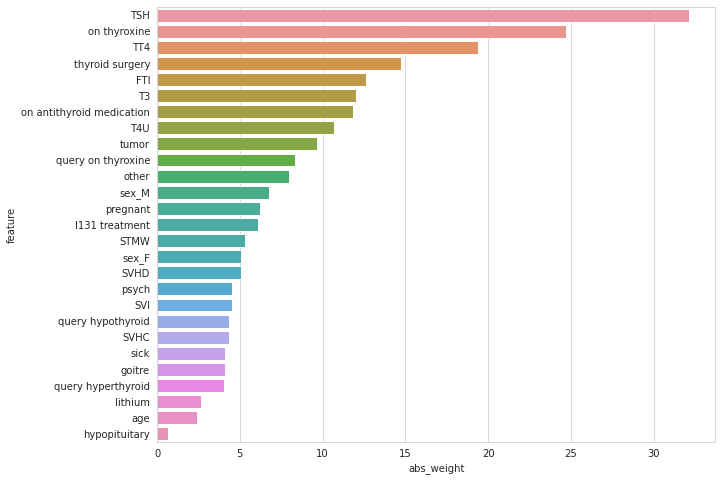

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
disp = sns.barplot(y='feature', x='abs_weight', data=importance, orient='h', ax=ax);
plt.show();

## Hyperparameters tuning

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
])
x_train_transformed = pipeline.fit_transform(x_train)

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=2000, multi_class='multinomial')
grid = {'C': np.logspace(-3, 3, 7)}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
logreg_cv = GridSearchCV(log_reg, grid, scoring=metrics['roc_auc_macro_ovo'], cv=cv)

logreg_cv.fit(x_train_transformed, y_train)

# print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
# print("accuracy :", logreg_cv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=57, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(roc_auc_score, needs_proba=

In [0]:
print('Best parameters: ', logreg_cv.best_params_)
print('roc_auc :', logreg_cv.best_score_)

Best parameters:  {'C': 10.0}
roc_auc : 0.9546514896926773


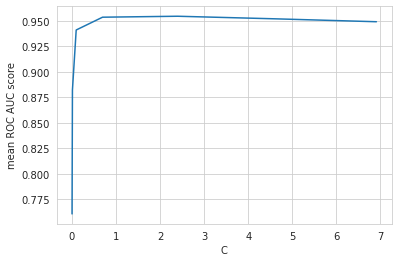

In [0]:
grid_scores = logreg_cv.cv_results_['mean_test_score']
data = pd.DataFrame({'params': np.log1p(grid['C']), 'grid_scores': grid_scores})

ax = sns.lineplot(x='params', y='grid_scores', data=data)
ax.set_xlabel('C');
ax.set_ylabel('mean ROC AUC score');

In [0]:
log_reg = LogisticRegression(penalty='l2', C=logreg_cv.best_params_['C'], max_iter=500, multi_class='multinomial')
evaluator.test_model('(L2) GridSearchCV', log_reg, x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Average cross-validation metrics
+-------------------+--------------------+---------------------+--------------------+
| model             | f1_micro           | neg_log_loss        | roc_auc_macro_ovo  |
+-------------------+--------------------+---------------------+--------------------+
| (L2) GridSearchCV | 0.8749661120761498 | 0.44789016493418127 | 0.9540825081778214 |
+-------------------+--------------------+---------------------+--------------------+


## F1-score threshold search

In [0]:
def search_threshold(y_true, y_proba, verbose=True):
  thresholds = []
  for thresh in np.arange(0.1, 0.81, 0.01):
    thresh = np.round(thresh, 2)
    res = f1_score(y_true, (y_proba > thresh).astype(int), average='micro')
    thresholds.append([thresh, res])
    if verbose:
      print("F1 score at threshold {0} is {1}".format(thresh, res))

  ths = thresholds.copy()
  thresholds.sort(key=lambda x: x[1], reverse=True)
  best_thresh = thresholds[0][0]
  print("Best threshold: ", best_thresh)
  return best_thresh, ths

In [0]:
model = evaluator.get_model('L2')

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
x_train_preprocessed = pipeline.fit_transform(x_train)
model.fit(x_train_preprocessed, y_train)

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_preprocessed = ohe.fit_transform(y_train.copy().to_numpy().reshape(-1, 1))
y_proba = model.predict_proba(x_train_preprocessed)

best_th, ths = search_threshold(y_train_preprocessed, y_proba, verbose=False);

Best threshold:  0.46


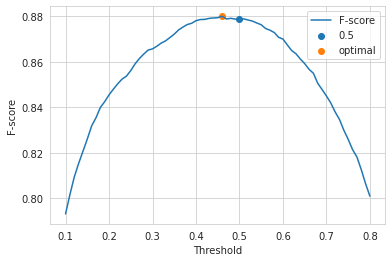

In [0]:
ths = np.array(ths)

plt.plot(ths[:, 0], ths[:, 1], label='F-score');
plt.scatter(0.5, ths[ths[:,0]==0.5, :][0][1], label='0.5');
plt.scatter(best_th, ths[ths[:,0]==best_th, :][0][1], label='optimal');
plt.xlabel('Threshold'); 
plt.ylabel('F-score'); 
plt.legend();

## Results

In [0]:
evaluator.print_scores()


Average cross-validation metrics
+-----------------------------+---------------------+---------------------+--------------------+
| model                       | f1_micro            | neg_log_loss        | roc_auc_macro_ovo  |
+-----------------------------+---------------------+---------------------+--------------------+
| Baseline                    | 0.8733301202561089  | 0.5013919079100155  | 0.9450214463653444 |
+-----------------------------+---------------------+---------------------+--------------------+
| L2                          | 0.8692392481845556  | 0.4443651811927085  | 0.9528786561200944 |
+-----------------------------+---------------------+---------------------+--------------------+
| (L2) 1.5 IQR                | 0.9153198653198652  | 0.2906418316167751  | 0.9407080292022338 |
+-----------------------------+---------------------+---------------------+--------------------+
| (L2) 3.0 IQR                | 0.8773564908895016  | 0.40991081766734966 | 0.949380060619346

### Test KNN SMOTEENN

**Train model**

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
])
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.fit_transform(x_test)

In [0]:
sampling_strategy = 'not majority'
se = SMOTEENN(sampling_strategy=sampling_strategy, random_state=RANDOM_SEED)
x_train_resampled_se, y_train_resampled_se = se.fit_resample(x_train_transformed, y_train.to_numpy())

In [0]:
y_train_resampled_se = pd.Series(y_train_resampled_se)

**Test model**

In [0]:
knn = KNeighborsClassifier(algorithm='kd_tree', weights='distance')
knn.fit(x_train_resampled_se, y_train_resampled_se)

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_test_ohe = ohe.fit_transform(y_test.to_numpy().reshape(-1, 1))

# y predicted
y_test_pred = knn.predict(x_test_transformed)
y_test_pred = ohe.fit_transform(y_test_pred.reshape(-1, 1))

# y predicted with threshold
y_test_proba = knn.predict_proba(x_test_transformed)
y_test_pred_th = (y_test_proba > best_th).astype(int)

Scores

In [0]:
# F-measure
f1_score_res = f1_score(y_test_ohe, y_test_pred, average='micro')
print("F-measure score: {}".format(f1_score_res))

# F-measure with optimal threshold
f1_score_th_res = f1_score(y_test_ohe, y_test_pred_th, average='micro')
print("F-measure with best threshold score: {}".format(f1_score_th_res))

# Log loss
log_loss_res = log_loss(y_test_ohe, y_test_pred)
print("Log loss score: {}".format(log_loss_res))

# ROC AUC
roc_auc_score_res = roc_auc_score(y_test_ohe, y_test_pred, average='macro', multi_class='ovo')
print("ROC AUC score: {}".format(roc_auc_score_res))

F-measure score: 0.7093784078516903
F-measure with best threshold score: 0.7123436650353453
Log loss score: 10.037714186743413
ROC AUC score: 0.8341462037673103


### Test Logistic regression with polynomial features

In [0]:
small_groups = ['S'] # Can't predict this class
y_train_res = y_train.replace(small_groups, 'grouped')
y_test_res = y_test.replace(small_groups, 'grouped')

**Train model**

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('poly', PolynomialFeatures(2))
])
x_train_transformed_poly_2 = pipeline.fit_transform(x_train)
x_test_transformed_poly_2 = pipeline.fit_transform(x_test)

**Test model**

In [0]:
log_reg = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', random_state=RANDOM_SEED)
log_reg.fit(x_train_transformed_poly_2, y_train_res)

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_test_ohe = ohe.fit_transform(y_test_res.to_numpy().reshape(-1, 1))

# y predicted
y_test_pred = log_reg.predict(x_test_transformed_poly_2)
y_test_pred = ohe.fit_transform(y_test_pred.reshape(-1, 1))

# y predicted with threshold
y_test_proba = log_reg.predict_proba(x_test_transformed_poly_2)
y_test_pred_th = (y_test_proba > best_th).astype(int)

Scores

In [0]:
# F-measure
f1_score_res = f1_score(y_test_ohe, y_test_pred, average='micro')
print("F-measure score: {}".format(f1_score_res))

# F-measure with optimal threshold
f1_score_th_res = f1_score(y_test_ohe, y_test_pred_th, average='micro')
print("F-measure with best threshold score: {}".format(f1_score_th_res))

# Log loss
log_loss_res = log_loss(y_test_ohe, y_test_pred)
print("Log loss score: {}".format(log_loss_res))

# ROC AUC
roc_auc_score_res = roc_auc_score(y_test_ohe, y_test_pred, average='macro', multi_class='ovo')
print("ROC AUC score: {}".format(roc_auc_score_res))

F-measure score: 0.8778625954198473
F-measure with best threshold score: 0.88113413304253
Log loss score: 4.2184765062486465
ROC AUC score: 0.7669137236464911
